# GLM in PyMC3: Out-Of-Sample Predictions

:::{post} Sept 20, 2021
:tags: generalized linear model
:category: intermediate
:::

In this notebook I explore GLMs with PyMC3. I am particularly interested in the model definition using [formulae](https://bambinos.github.io/formulae/) formulas, as it makes the model evaluation loop faster (easier to include features and/or interactions). There are many good resources on this subject, but most of them evaluate the model in-sample. For many applications we require doing predictions on out-of-sample data. This experiment was motivated by the discussion of the thread ["Out of sample" predictions with the GLM sub-module](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) on the (great!) forum [PyMC Discourse](https://discourse.pymc.io/), thank you all for your input!

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import xarray as xr

from formulae import design_matrices
from matplotlib import cm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Generate Sample Data

We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [3]:
# Number of data points.
n = 250
# Create features.
x1 = rng.normal(loc=0.0, scale=2.0, size=n)
x2 = rng.normal(loc=0.0, scale=2.0, size=n)
epsilon = rng.normal(loc=0.0, scale=0.5, size=n)
# Define target variable.
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = 1 / (1 + np.exp(-z))
y = rng.binomial(n=1, p=p, size=n)

df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))

df.head()

,x1,x2,y
0,-0.445284,1.381325,0
1,2.651317,0.800736,1
2,-1.141940,-0.128204,0
3,1.336498,-0.931965,0
4,2.290762,3.400222,1


Let us do some exploration of the data:

/home/ada/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


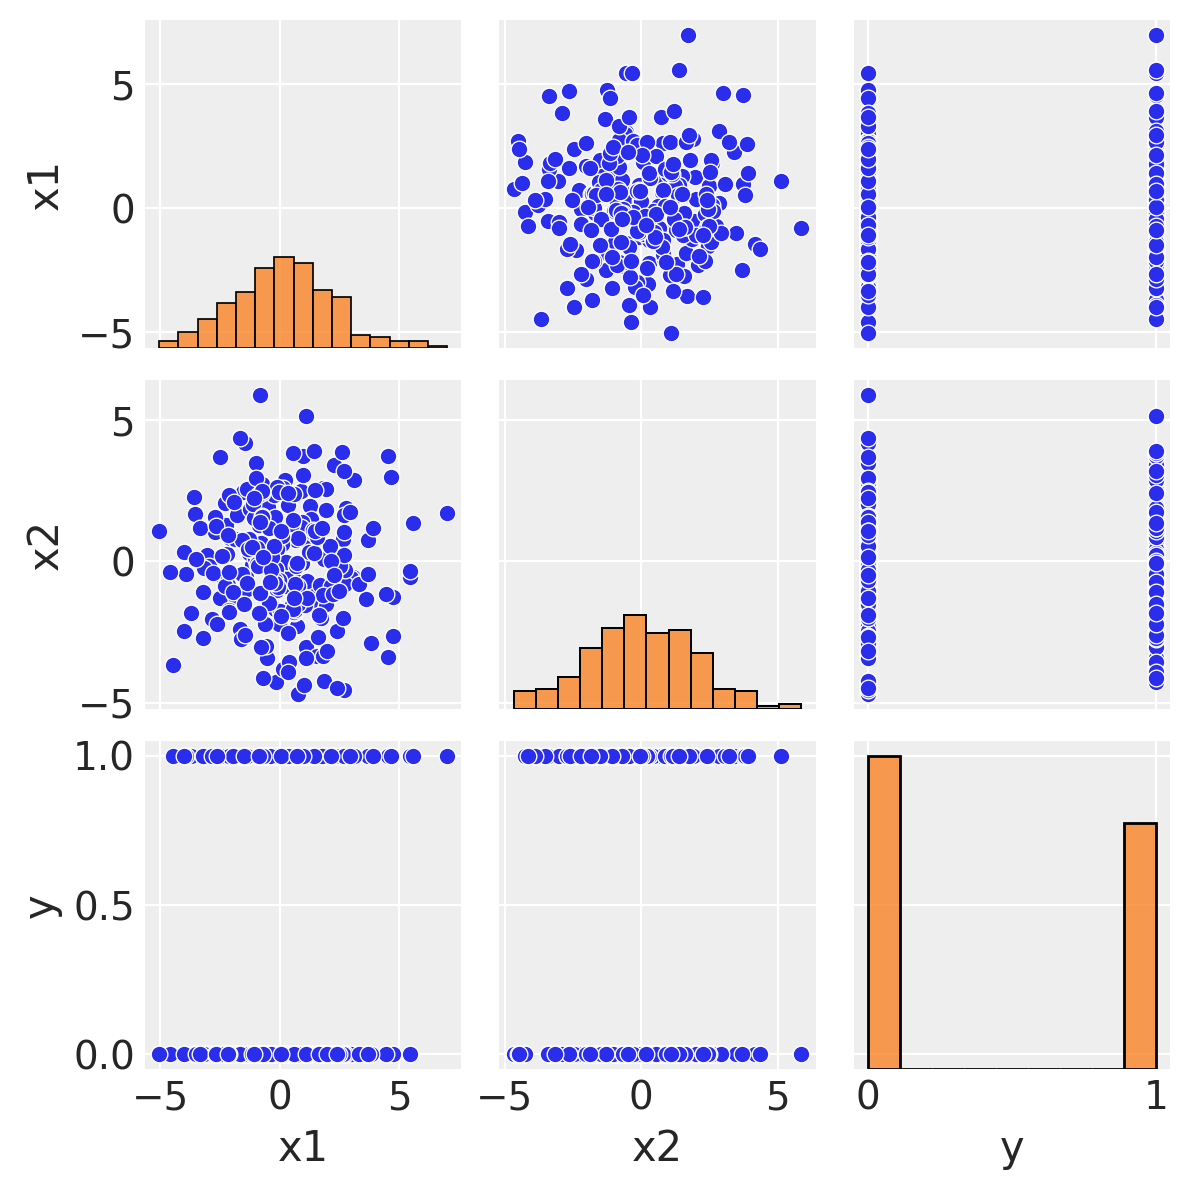

In [4]:
sns.pairplot(data=df, kind="scatter", height=2, plot_kws={"color": "C0"}, diag_kws={"color": "C1"});

- $x_1$ and $x_2$ are not correlated.
- $x_1$ and $x_2$ do not seem to separate the $y$-classes independently.
- The distribution of $y$ is not highly unbalanced.

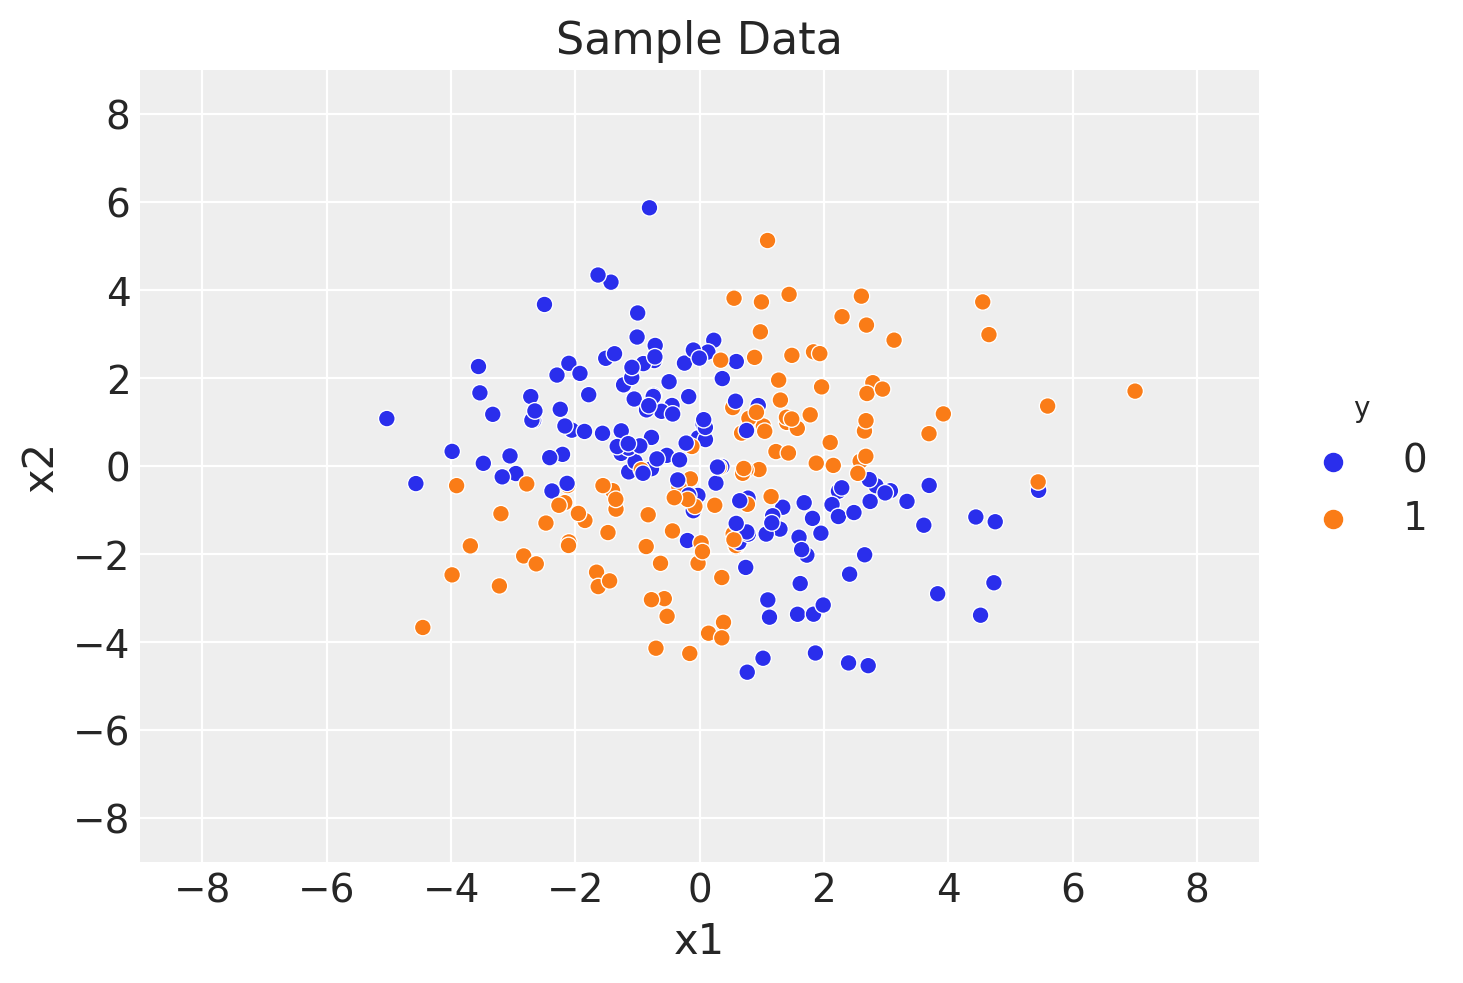

In [5]:
fig, ax = plt.subplots()
sns.scatterplot(x="x1", y="x2", data=df, hue="y", palette=["C0", "C1"])
ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Sample Data", xlim=(-9, 9), ylim=(-9, 9));

## Prepare Data for Modeling

I created the features from a formula using [formulae](https://bambinos.github.io/formulae/).

In [6]:
# Define model formula.
formula = "y ~ x1 * x2"
# Create features.
dm = design_matrices("y ~ x1 * x2", data=df)

y, x = dm.response.design_vector.flatten(), dm.common.design_matrix
labels = list(dm.common.terms_info.keys())

As pointed out on the [thread](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) (thank you @Nicky!), we need to keep the labels of the features in the design matrix.

In [7]:
print(f"labels = {labels}")

labels = ['Intercept', 'x1', 'x2', 'x1:x2']


Now we do a train-test split.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=RANDOM_SEED)

data = pd.concat(
    [pd.DataFrame(x_train, columns=labels), pd.DataFrame(y_train, columns=["y"])], axis=1
)

## Define and Fit the Model

We now specify the model in PyMC3.

In [9]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=10),
    "x1": bmb.Prior("Normal", mu=0, sd=10),
    "x2": bmb.Prior("Normal", mu=0, sd=10),
    "x1:x2": bmb.Prior("Normal", mu=0, sd=10),
}

model = bmb.Model(formula=formula, data=data, family="bernoulli", priors=priors)
trace = model.fit(draws=2000, chains=5, tune=1000, target_accept=0.87, random_seed=RANDOM_SEED)

Modeling the probability that y==1
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [Intercept, x1:x2, x2, x1]


Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 13 seconds.


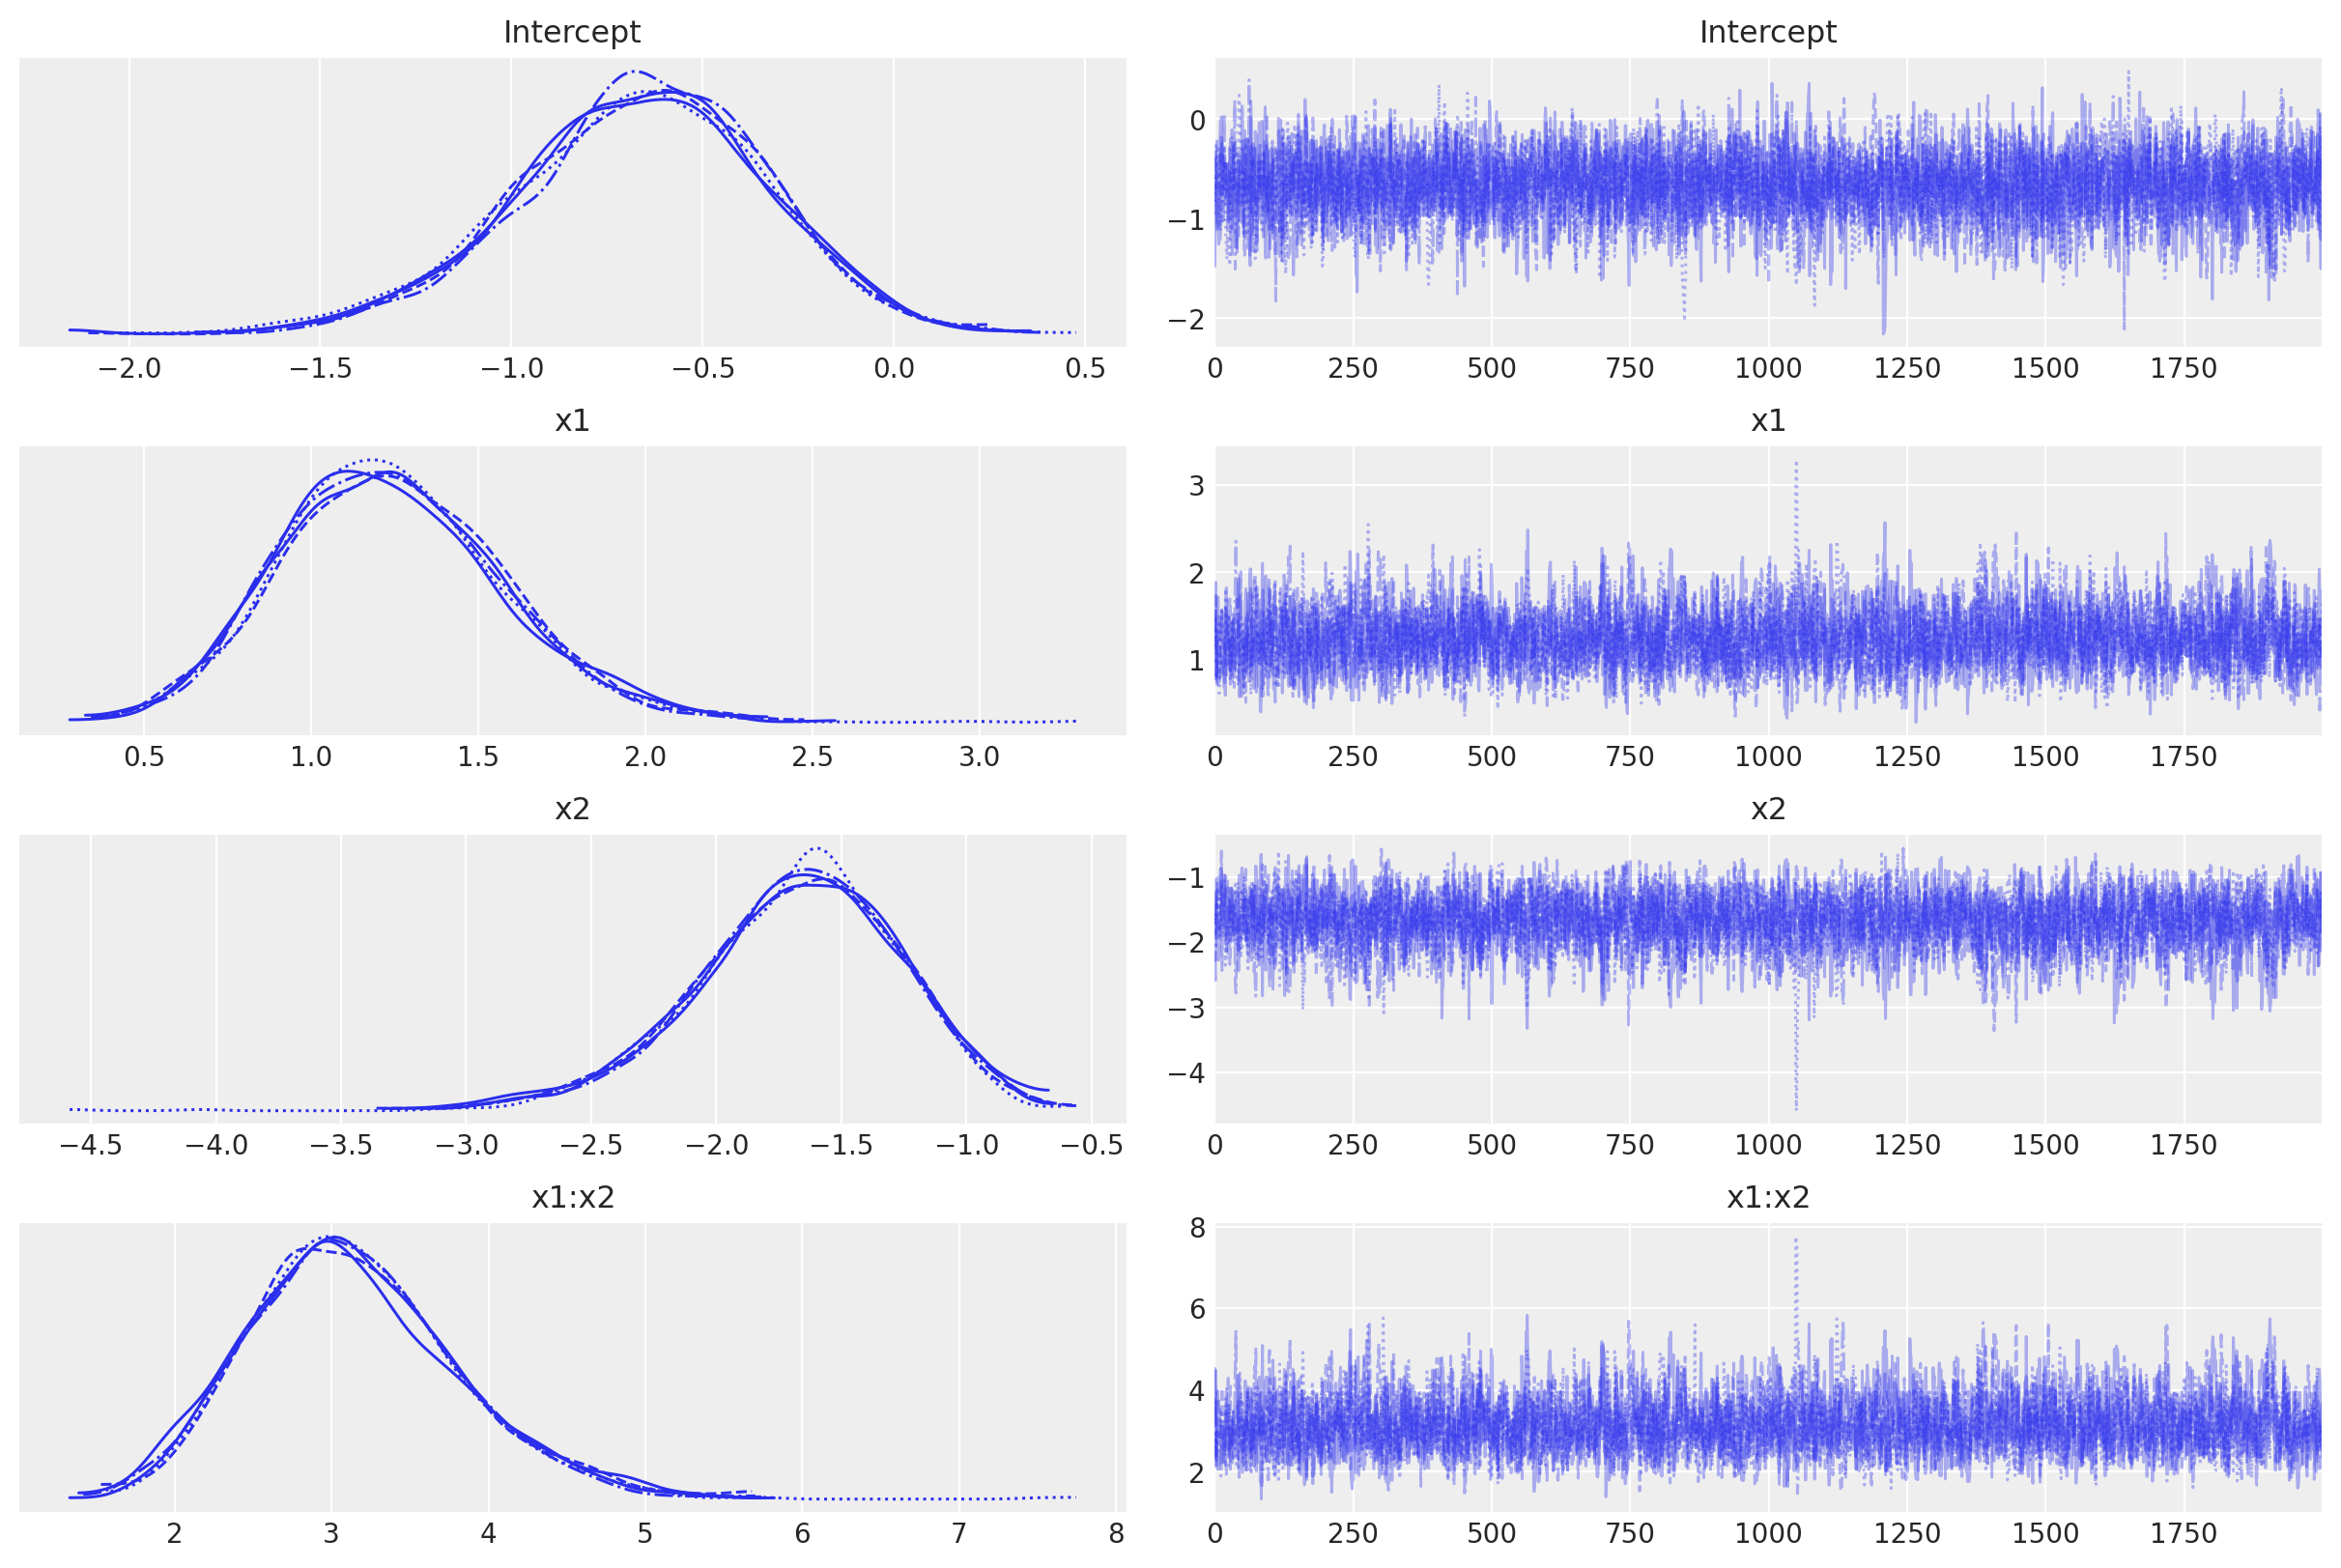

In [10]:
# Plot chains.
az.plot_trace(trace);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.665,0.327,-1.266,-0.029,0.005,0.004,4119.0,4286.0,1.0
x1,1.239,0.330,0.633,1.868,0.006,0.004,2835.0,3639.0,1.0
x2,-1.674,0.412,-2.465,-0.937,0.008,0.006,2747.0,3565.0,1.0
x1:x2,3.142,0.669,1.932,4.416,0.013,0.009,2652.0,3300.0,1.0


The chains look good.

## Generate Out-Of-Sample Predictions

Now we generate predictions on the test set.

In [12]:
# Generate posterior samples.
model.predict(trace, kind="pps", data=pd.DataFrame(x_test, columns=labels), draws=1000)

In [13]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
p_test_pred = trace.posterior_predictive["y"].mean(("chain", "draw")).values
y_test_pred = (p_test_pred >= 0.5).astype("int")

## Evaluate Model

First let us compute the accuracy on the test set.

In [14]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.947


Next, we plot the [roc curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and compute the [auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

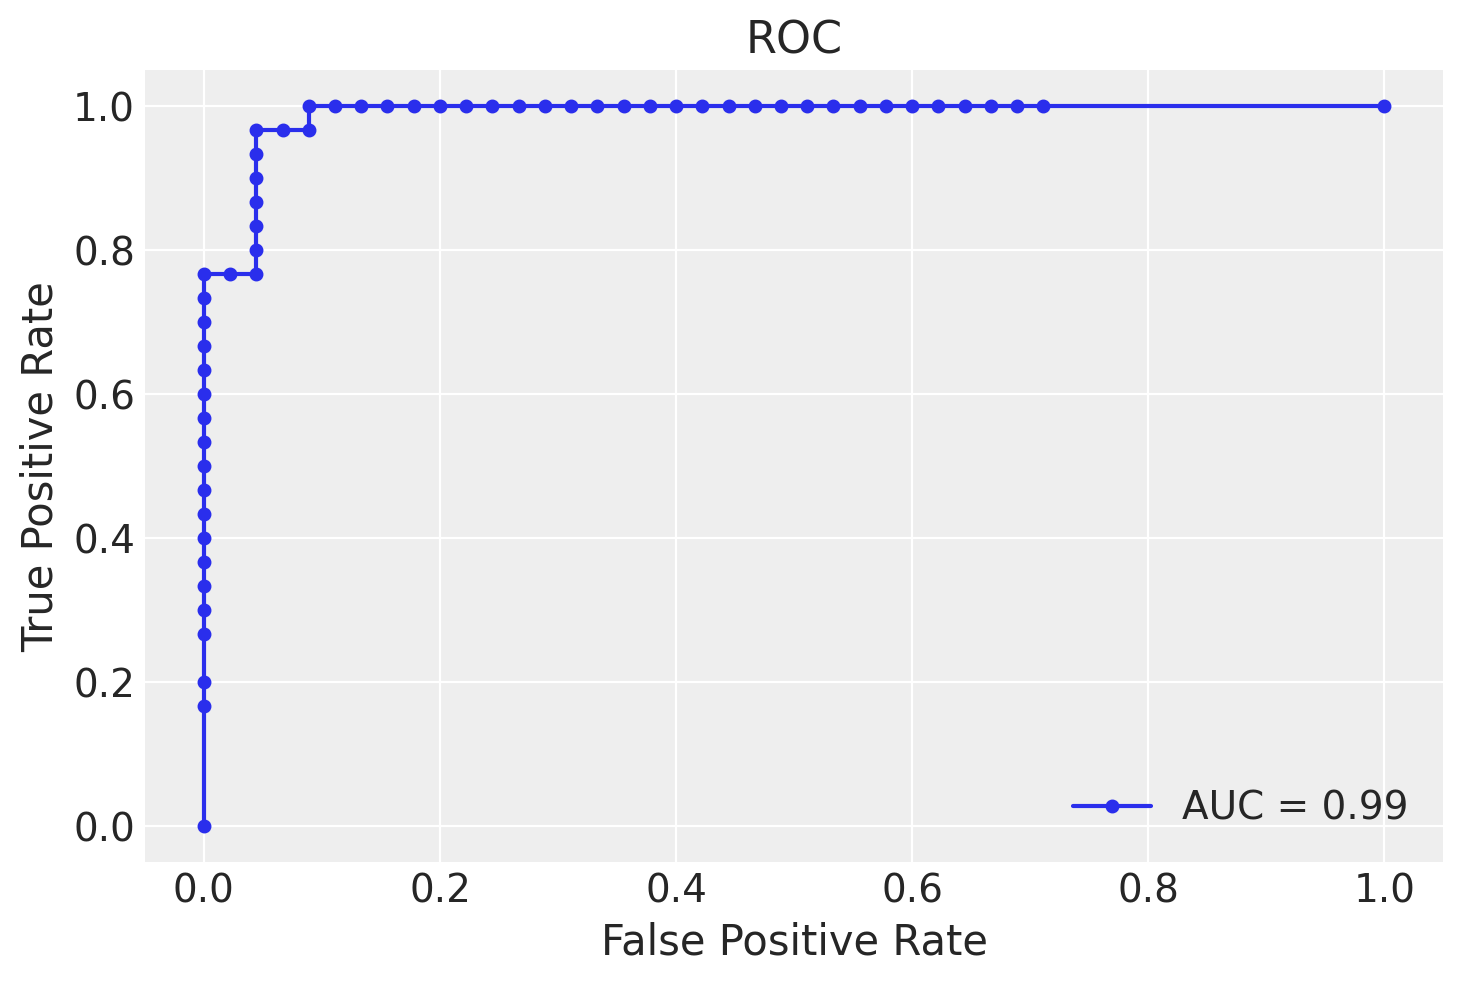

In [15]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", color="C0", markersize=4)
ax.set(title="ROC");

The model is performing as expected (we of course know the data generating process, which is almost never the case in practical applications).

## Model Decision Boundary

Finally we will describe and plot the model decision boundary, which is the space defined as

$$\mathcal{B} = \{(x_1, x_2) \in \mathbb{R}^2 \: | \: p(x_1, x_2) = 0.5\}$$

where $p$ denotes the probability of belonging to the class $y=1$ output by the model. To make this set explicit, we simply write the condition in terms of the model parametrization:

$$0.5 = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2))}$$

which implies

$$0 = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2$$

Solving for $x_2$ we get the formula

$$x_2 = - \frac{\beta_0 + \beta_1 x_1}{\beta_2 + \beta_{12}x_1}$$

Observe that this curve is a hyperbola centered at the singularity point $x_1 = - \beta_2 / \beta_{12}$.

Let us now plot the model decision boundary using a grid:

In [16]:
# Construct grid.
grid = np.linspace(start=-9, stop=9, num=200)
x1_mesh, x2_mesh = np.meshgrid(grid, grid)

x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)
new_data = pd.DataFrame(x_grid, columns=["x1", "x2"])

# Generate model predictions on the grid.
model.predict(trace, kind="pps", data=new_data, draws=1000)

Now we compute the model decision boundary on the grid for visualization purposes. 

In [17]:
numerator = -(trace.posterior["Intercept"] + trace.posterior["x1"] * xr.DataArray(grid))
denominator = trace.posterior["x2"] + trace.posterior["x1:x2"] * xr.DataArray(grid)
bd_grid = numerator / denominator

new_data["p"] = trace.posterior_predictive["y"].mean(("chain", "draw"))
new_data.sort_values("p", inplace=True)

p_grid = new_data.pivot(index="x2", columns="x1", values="p").to_numpy()

We finally get the plot and the predictions on the test set:

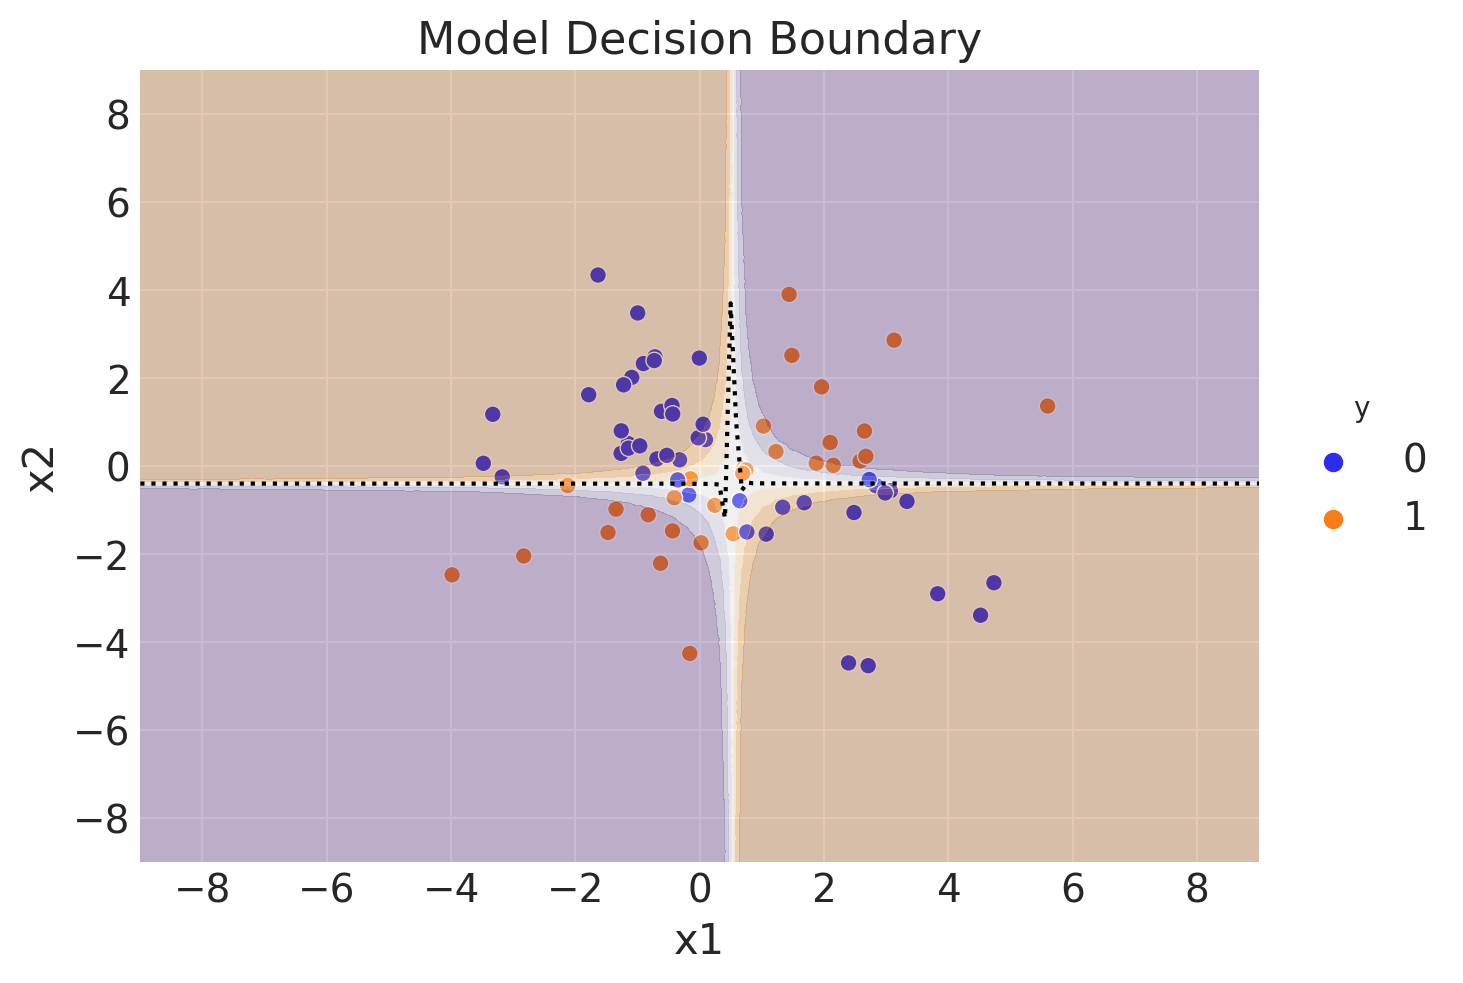

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    palette=["C0", "C1"],
    ax=ax,
)
sns.lineplot(x=grid, y=bd_grid.mean(("chain", "draw")), color="black", ax=ax)
ax.contourf(grid, grid, p_grid, cmap=cm.PuOr, alpha=0.3)
ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.lines[0].set_linestyle("dotted")
ax.set(title="Model Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="x1", ylabel="x2");

## References

:::{bibliography}
:filter: docname in docnames

capretto2020bambi
mcelreath2018statistical
martin2018bap
:::

## Watermark

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano

Last updated: Sun Oct 10 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

theano: 1.1.2

pymc3     : 3.11.2
pandas    : 1.2.1
numpy     : 1.19.5
arviz     : 0.11.2
matplotlib: 3.3.4
seaborn   : 0.11.1
xarray    : 0.17.0
bambi     : 0.6.0

Watermark: 2.2.0

